<a href="https://colab.research.google.com/github/AlbertoLuizRT/image_processing/blob/master/AppVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AppVision - Seu App em Minutos

Projeto desenvolvido para a disciplina de Visão Computacional - 2019.1

##Processamento incial
Imports iniciais necessários para a aplicação e processamento inicial da imagem: load, conversão para greyscalse e limiarização da imagem.


Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
libleptonica-dev is already the newest version (1.75.3-3).
libtesseract-dev is already the newest version (4.00~git2288-10f4998a-2).
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


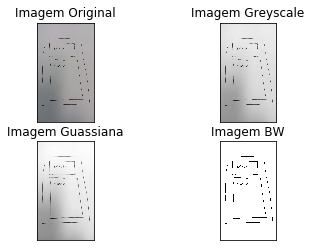

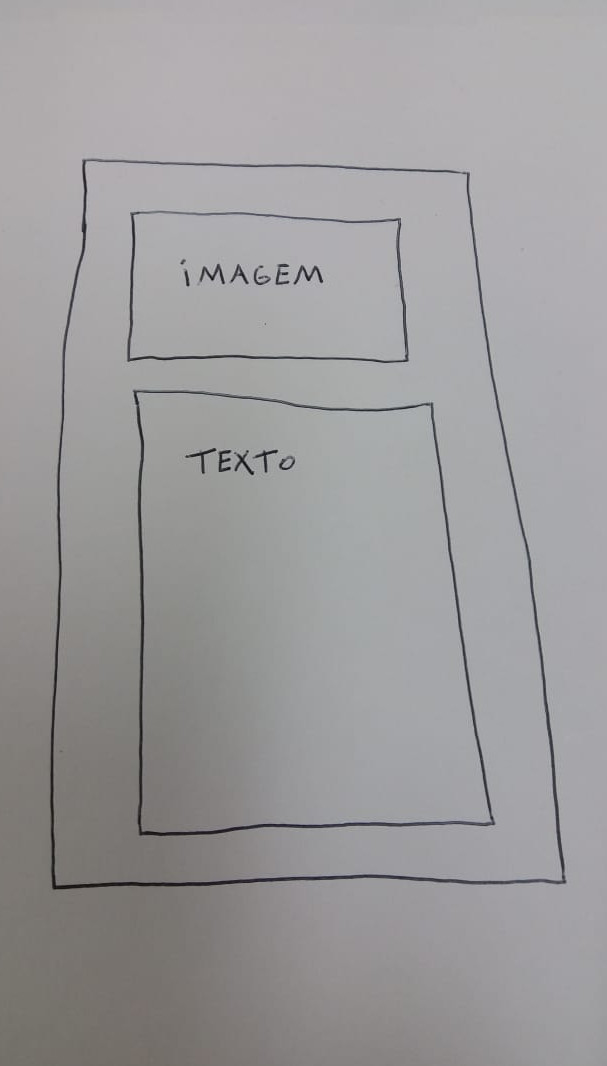

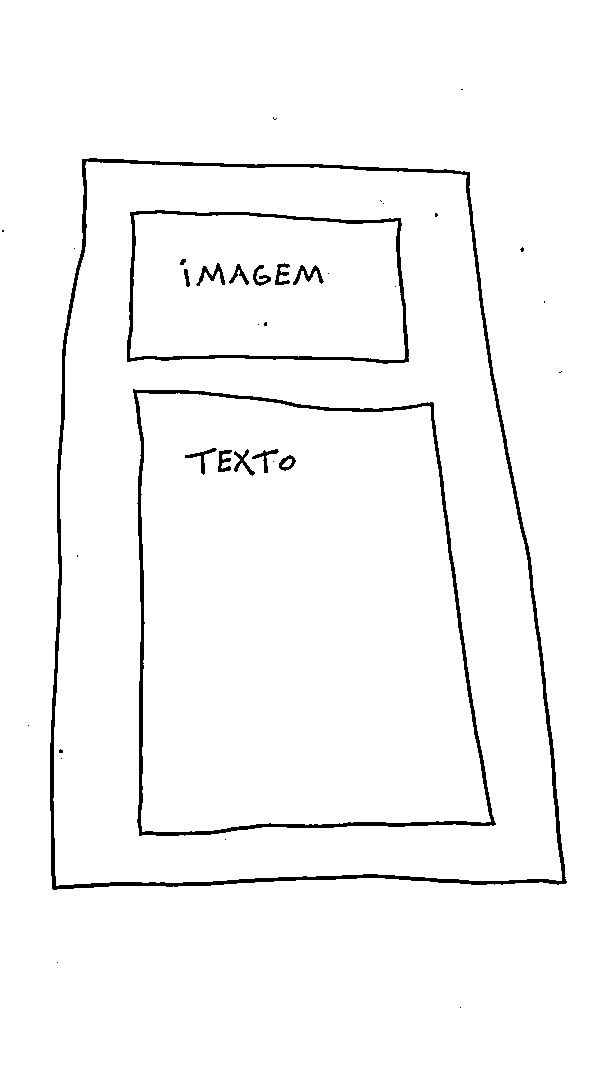

In [ ]:
!apt-get install tesseract-ocr libtesseract-dev libleptonica-dev pkg-config
!pip install tesserocr

import math
from google.colab.patches import cv2_imshow
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

original_image = cv2.imread('/content/e0e55abb-fd82-46d5-844a-4d8672f622fd.jpeg')
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)
# Might wanna change the window size or constant, the last 2 variables
thres_image = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY,11,2)

images = [original_image,  gray_image, blurred, thres_image]
titles = ['Imagem Original', 'Imagem Greyscale', 'Imagem Guassiana', 'Imagem BW']

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()
cv2_imshow(original_image)
cv2_imshow(thres_image)

###Importante!

Verifique se os elementos da imagem ficaram corretamente binarizados, caso contrário, modifique os atributos 5 e 6 da linha de código que faz a limiarização: o 5º argumento representa o tamanho da janela onde será calculada a Gaussiana e o 6º uma constante que será subtraída.

##Deteccção de elementos base

Agora que já temos a imagem corretamente processada, com todos os elementos visíveis e binarizados, podemos iniciar a detecção destes elementos. Utilizaremos a função findContours() para achar os polígonos presentes na imagem e deprezaremos os que não tiverem 4 vétrices e que tenham menos que 1000px de área, que consideraremos ruído.

É importante também que a linha esteja na largura correta, para que não ocorram erros na detecção. Para garantir uma boa largura e a absência de falhas na linha, aplicaremos o fechamento na imagem, sem apagar a imagem original, que depois utilizaremos para detectar o texto escrito e classificar os retângulos por tipo de componente.

3


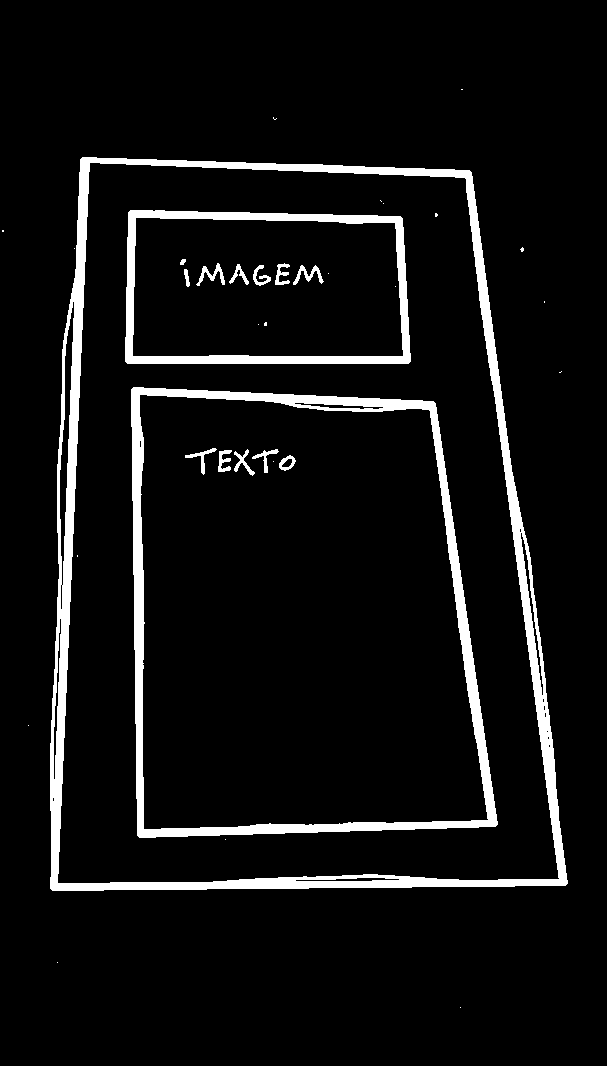

In [ ]:
inv_image = cv2.bitwise_not(thres_image)

kernel = np.ones((10,10),np.uint8)
# closed_image = cv2.morphologyEx(inv_image, cv2.MORPH_CLOSE, kernel)
# open_image = cv2.morphologyEx(closed_image, cv2.MORPH_OPEN, kernel)

contoured_img, contours, _hierarchy = cv2.findContours(inv_image, cv2.RETR_LIST,
                                             cv2.CHAIN_APPROX_SIMPLE)
                                                       
def angle_cos(p0, p1, p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) )
                                                       
squares = []
for cnt in contours:
    cnt_len = cv2.arcLength(cnt, True)
    cnt = cv2.approxPolyDP(cnt, 0.02*cnt_len, True)
    if len(cnt) == 4 and cv2.contourArea(cnt) > 1000 and cv2.isContourConvex(cnt):
        cnt = cnt.reshape(-1, 2)
        max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in range(4)])
        if max_cos < 0.2:
            squares.append(cnt)

cv2.drawContours(inv_image, squares, -1, (255, 0, 255), 3)
print(int(len(squares)/2))
cv2_imshow(inv_image)


## Detecção de texto

Precisamos agora reconhecer as strings escritas a mão dentros dos quadrados detectados. Temos a localização dos vetores de arestas de cada um dos quadrados, dessa forma, fica fácil saber se um texto está dentro ou não de um dos quadrados sabendo também a localização dele. Utilizaremos a biblioteca Tesseract do Google para analisar a imagem e extrair as strings para classificar os quadrados por tipo.

In [ ]:
from PIL import Image
from tesserocr import PyTessBaseAPI, RIL

image = Image.open('/content/e0e55abb-fd82-46d5-844a-4d8672f622fd.jpeg')

with PyTessBaseAPI() as api:
    api.SetImage(image)
    boxes = api.GetComponentImages(RIL.TEXTLINE, True)
    print('Found {} textline image components.'.format(len(boxes)))
    for i, (im, box, _, _) in enumerate(boxes):
        # im is a PIL image object
        # box is a dict with x, y, w and h keys
        api.SetRectangle(box['x'], box['y'], box['w'], box['h'])
        ocrResult = api.GetUTF8Text()
        conf = api.MeanTextConf()
        print(u"Box[{0}]: x={x}, y={y}, w={w}, h={h}, "
              "confidence: {1}, text: {2}".format(i, conf, ocrResult, **box))

Found 1 textline image components.
Box[0]: x=180, y=259, w=143, h=28, confidence: 77, text: \MAGEM

